In [ ]:
# Imports
import torch
import time
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader , random_split
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download FashionMnist Dataset
train_dataset = datasets.FashionMNIST(root='data',
                                      download=True,
                                      train=True,
                                      transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root='data',
                                      train=False,
                                      transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 13795603.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 230723.85it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4236220.73it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16803328.40it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# Get Validation set
generator1 = torch.Generator().manual_seed(42)    # for reproducible results
validation_size= int(0.1* (len(train_dataset)))
train_size = int(len(train_dataset) - validation_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, validation_size], generator=generator1)

In [ ]:
# Settings
Batch_size = 256
Seed = 21
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For general reproducibility
torch.manual_seed(Seed)
#torch.use_deterministic_algorithms(True)


In [ ]:
# Load datasets into Dataloader for iterating over the datasets
train_loader = DataLoader(train_dataset, batch_size = Batch_size, shuffle=True, drop_last=True,)
valid_loader = DataLoader(valid_dataset, batch_size = Batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle=False)


In [ ]:
# Check dataset
for features, label in train_loader:
  print(f'Image dimension - {features.shape}')
  print(f'Label dimension - {label.shape}')
  print(f'Class labels of 10 examples - {label[:10]}')
  break

Image dimension - torch.Size([256, 1, 28, 28])
Label dimension - torch.Size([256])
Class labels of 10 examples - tensor([1, 3, 0, 8, 6, 3, 7, 1, 3, 0])


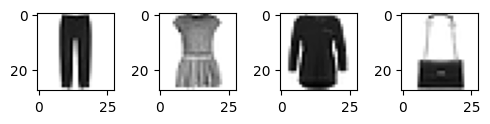

In [ ]:
# Display some images
fig, ax = plt.subplots(1, 4, figsize = (6, 1))
for idx, image in enumerate(features[:4]):
    ax[idx].imshow((image.reshape(28,28)),cmap='binary')

In [ ]:
# Model
class MultilayerPerceptron(torch.nn.Module):
  def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
    super().__init__()

    self.network= torch.nn.Sequential(
        # first hidden layer
        torch.nn.Flatten(),
        torch.nn.Linear(num_features , num_hidden_1,bias=False),
        torch.nn.BatchNorm1d(num_hidden_1),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.6),

        # second hidden layer
        torch.nn.Linear(num_hidden_1, num_hidden_2,bias=False),
        torch.nn.BatchNorm1d(num_hidden_2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.6),

        # output layer
        torch.nn.Linear(num_hidden_2, num_classes)
        )


  def forward(self, x):
    logits = self.network(x)
    return logits

In [ ]:
# Initialise model
model= MultilayerPerceptron( num_features = 28*28, num_classes = 10, num_hidden_1 =500, num_hidden_2 = 400)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min',
                                                       verbose=True)

In [ ]:
# Define accuracy function
def compute_accuracy(model, data_loader):
    correct, num_examples = 0, 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        num_examples += labels.size(0)
    return (correct / num_examples) * 100


In [ ]:
# Training the Model

mini_batch_loss, train_acc_list, valid_acc_list = [], [], []

start_time = time.time()
for epoch in range(num_epochs):
    model.train()  # set model in train mode
    for batch_idx, (features, label) in enumerate(train_loader):

        features = features.to(device)
        label = label.to(device)

        # Compute logits
        logits = model(features)
        # Compute loss
        loss = F.cross_entropy(logits, label)
        optimizer.zero_grad()
        # Backprops
        loss.backward()
        # Update gradient
        optimizer.step()

        # Logging
        mini_batch_loss.append(loss.item())
        if batch_idx % 50 ==0 :
           print(f'Epoch : {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader)} | Loss : {loss.item():.3f}')

    model.eval()
    with torch.no_grad():  # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        print(f'Epoch : {epoch+1:03d}/{num_epochs:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
        print(f'Time elapsed: {(((time.time() - start_time)/60)):.2f} min')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    # lR scheduler
    scheduler.step(mini_batch_loss[-1])

total_time_elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {total_time_elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch : 001/050 | Batch 000/210 | Loss : 2.541
Epoch : 001/050 | Batch 050/210 | Loss : 0.604
Epoch : 001/050 | Batch 100/210 | Loss : 0.662
Epoch : 001/050 | Batch 150/210 | Loss : 0.545
Epoch : 001/050 | Batch 200/210 | Loss : 0.563
Epoch : 001/050 | Train: 82.16% | Validation: 81.80%
Time elapsed: 0.41 min
Epoch : 002/050 | Batch 000/210 | Loss : 0.578
Epoch : 002/050 | Batch 050/210 | Loss : 0.602
Epoch : 002/050 | Batch 100/210 | Loss : 0.611
Epoch : 002/050 | Batch 150/210 | Loss : 0.586
Epoch : 002/050 | Batch 200/210 | Loss : 0.581
Epoch : 002/050 | Train: 80.31% | Validation: 79.87%
Time elapsed: 0.77 min
Epoch : 003/050 | Batch 000/210 | Loss : 0.575
Epoch : 003/050 | Batch 050/210 | Loss : 0.659
Epoch : 003/050 | Batch 100/210 | Loss : 0.573
Epoch : 003/050 | Batch 150/210 | Loss : 0.640
Epoch : 003/050 | Batch 200/210 | Loss : 0.616
Epoch : 003/050 | Train: 80.75% | Validation: 80.33%
Time elapsed: 1.08 min
Epoch : 004/050 | Batch 000/210 | Loss : 0.640
Epoch : 004/050 | Ba

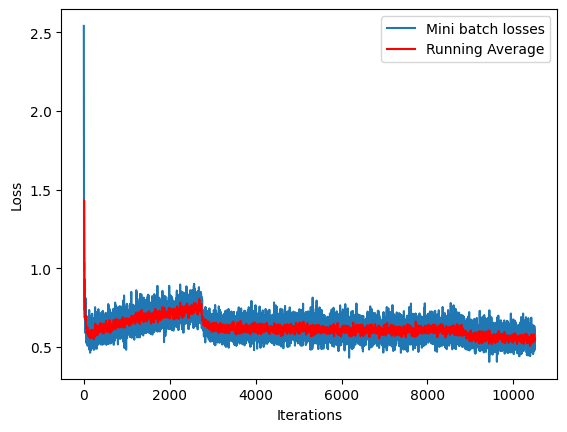

In [ ]:
# Get running average
def running_average(data, window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

# Calculate the running average of minibatch loss
window_size = 10
avg_losses = running_average(mini_batch_loss, window_size)

# Plotting
plt.plot(mini_batch_loss, label='Mini batch losses')
plt.plot(np.arange(window_size - 1, len(mini_batch_loss)), avg_losses, label='Running Average', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

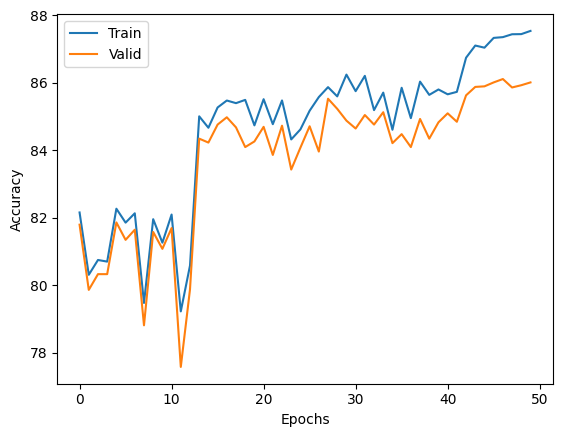

In [ ]:
# Plot of train and validation accuracies
plt.plot(train_acc_list, label='Train')
plt.plot(valid_acc_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()